In [2]:
import pandas as pd

df = pd.read_csv('dataset_wparticipant_v2.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6034221 entries, 0 to 6034220
Data columns (total 80 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   advertisement_id                              int64  
 1   lot_id                                        int64  
 2   fw_item_price                                 float64
 3   fw_total_price                                float64
 4   fw_discount                                   float64
 5   fw_total_price_wdiscount                      float64
 6   sw_item_price                                 float64
 7   sw_total_price                                float64
 8   sw_discount                                   float64
 9   sw_total_price_wdiscount                      float64
 10  lot_number                                    object 
 11  lot_name                                      object 
 12  lot_description                               object 
 1

In [3]:
simple_df = df[["sw_total_price_wdiscount", "total_amount"]]

In [4]:
simple_df.shape

(6034221, 2)

In [5]:
simple_df = simple_df.dropna()
simple_df.shape

(5678990, 2)

In [10]:
print(simple_df["sw_total_price_wdiscount"].describe())
print(simple_df["total_amount"].describe())

count    5.678990e+06
mean     3.030388e+06
std      8.746340e+07
min      0.000000e+00
25%      1.300000e+04
50%      5.160000e+04
75%      2.371600e+05
max      4.897984e+10
Name: sw_total_price_wdiscount, dtype: float64
count    5.678990e+06
mean     3.491632e+06
std      9.498054e+07
min      0.000000e+00
25%      2.000000e+04
50%      7.786586e+04
75%      3.300000e+05
max      5.370597e+10
Name: total_amount, dtype: float64


In [6]:
simple_df = simple_df.loc[~(simple_df==0).any(axis=1)]

In [17]:
from statsmodels.formula.api import ols

In [20]:
simple_df["target"] = simple_df["sw_total_price_wdiscount"] + 1

simple_lin_reg = ols("target ~ total_amount", simple_df).fit()

simple_lin_reg.params

Intercept      -160351.956592
total_amount         0.919007
dtype: float64

KeyboardInterrupt: 

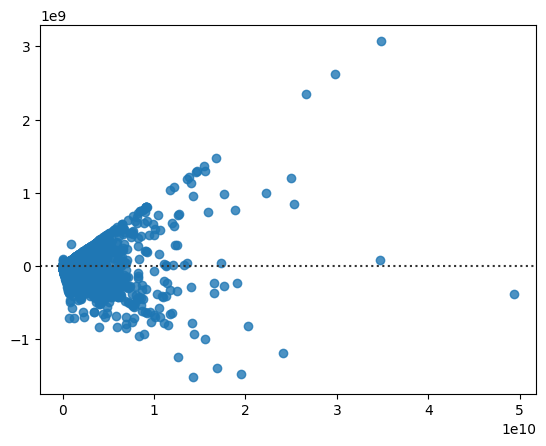

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtain fitted values and residuals
fitted_values = simple_lin_reg.fittedvalues
residuals = simple_lin_reg.resid

# Plot residuals vs. fitted values
sns.residplot(x=fitted_values, y=residuals, lowess=True, line_kws={"color": "red"})

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


In [25]:
simple_lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.342e+09
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:57:45   Log-Likelihood:            -9.2678e+07
No. Observations:             5460960   AIC:                         1.854e+08
Df Residuals:                 5460958   BIC:                         1.854e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.604e+05   2431.227    -65.955      0.000   -1.65e+05   -1.56e+05
total_amount     0.9190   2.51e-05   3.66e+04      0.000       0.919       0.919
===============================================================================
Omnibus:                 18507184.049   Durbin-Watson:                    1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   411737628743744.062
Skew:                          59.822   Prob(JB):                          0.00
Kurtosis:                   42541.256   Cond. No.                      9.70e+07
===============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.7e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

KeyboardInterrupt: 

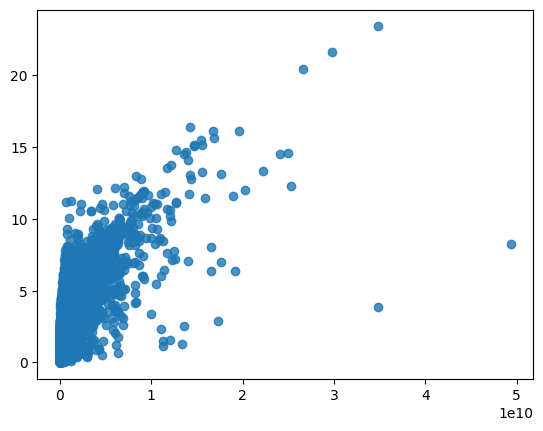

In [31]:
# Preprocessing steps
model_norm_residuals = simple_lin_reg.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# Create the scale-location plot
sns.regplot(x=simple_lin_reg.fittedvalues, y=model_norm_residuals_abs_sqrt, ci=None, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Sqrt of abs val of stdized residuals")

# Show the plot
plt.show()

In [29]:
import statsmodels.api as sm

# Create quantile bins for stratified sampling
simple_df["bin"] = pd.qcut(simple_df["total_amount"], q=10)  # 10 bins

# Sample from each bin
sampled_data = simple_df.groupby("bin").apply(lambda x: x.sample(n=100, random_state=42)).reset_index(drop=True)

# Residual plot
sns.residplot(
    x=simple_lin_reg.fittedvalues.loc[sampled_data.index],
    y=simple_lin_reg.resid.loc[sampled_data.index],
    lowess=True,
    line_kws={"color": "red"}
)

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Stratified Sampling)")
plt.show()

/var/folders/yr/yydj312117b_npm8qzq0jhf40000gn/T/ipykernel_78835/1485467769.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_data = simple_df.groupby("bin").apply(lambda x: x.sample(n=100, random_state=42)).reset_index(drop=True)
/var/folders/yr/yydj312117b_npm8qzq0jhf40000gn/T/ipykernel_78835/1485467769.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = simple_df.groupby("bin").apply(lambda x: x.sample(n=100, random_state=42)).reset_index(drop=True)


KeyError: '[21, 61, 171, 253, 262, 285, 291, 292, 312, 313, 333, 338, 348, 367, 374, 392, 394, 402, 406, 408, 417, 442, 444, 456, 472, 475, 506, 510, 512, 519, 523, 530, 557, 559, 589, 611, 643, 650, 668, 680, 694, 704, 710, 714, 717, 722, 741, 746, 754, 756, 760, 768, 769, 770, 780, 798, 812, 825, 833, 836, 843, 844, 858, 873, 876, 877, 878, 888, 889, 894, 897, 912, 917, 931, 933, 934, 935, 936, 937, 939, 940, 942, 944, 946, 948, 955, 970, 971, 973, 975, 981, 983, 984, 985, 987, 990, 995, 997] not in index'

In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mean_total_amount = simple_df["total_amount"].mean()
std_total_amount = simple_df["total_amount"].std()

# Filter rows within 1 standard deviation of the mean
filtered_data = simple_df[
    (simple_df["total_amount"] >= mean_total_amount - std_total_amount) &
    (simple_df["total_amount"] <= mean_total_amount + std_total_amount)
]

filtered_data["target"] = filtered_data["sw_total_price_wdiscount"] + 1

filtered_model = ols("target ~ total_amount +0", data = filtered_data).fit()

# Print the summary of the new model
print(filtered_model.params)
print(filtered_model.summary())

/var/folders/yr/yydj312117b_npm8qzq0jhf40000gn/T/ipykernel_81697/2567912253.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["target"] = filtered_data["sw_total_price_wdiscount"] + 1


total_amount    0.852287
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.975
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                          2.127e+08
Date:                Mon, 16 Dec 2024   Prob (F-statistic):                        0.00
Time:                        19:45:02   Log-Likelihood:                     -8.1032e+07
No. Observations:             5438202   AIC:                                  1.621e+08
Df Residuals:                 5438201   BIC:                                  1.621e+08
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]

In [ ]:
import seaborn as sns
# Residual plot for the filtered model
sns.residplot(
    x=filtered_model.fittedvalues, 
    y=filtered_model.resid, 
    lowess=True, 
    line_kws={"color": "red"}
)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Filtered Data within 1 STD)")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [33]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
X = simple_df[["total_amount"]]
y = simple_df["sw_total_price_wdiscount"] + 1

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict with Linear Model
y_pred_linear = lin_reg.predict(X_test)

# Transform target to log-space
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Train Logarithmic Model
log_reg = LinearRegression()
log_reg.fit(X_train, y_train_log)

# Predict in log-space
y_pred_log = log_reg.predict(X_test)

# Convert predictions back to original scale
y_pred_log_exp = np.exp(y_pred_log)

# Evaluate Linear Model
r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)

# Evaluate Logarithmic Model
r2_log = r2_score(y_test, y_pred_log_exp)
mse_log = mean_squared_error(y_test, y_pred_log_exp)

# Display results
print("Linear Model:")
print(f"  R² Score: {r2_linear}")
print(f"  MSE: {mse_linear}")

print("\nLogarithmic Model:")
print(f"  R² Score: {r2_log}")
print(f"  MSE: {mse_log}")


Linear Model:
  R² Score: 0.9969370753674699
  MSE: 23035911950910.86

Logarithmic Model:
  R² Score: -8.219430416096855e+145
  MSE: 6.18174124628848e+161


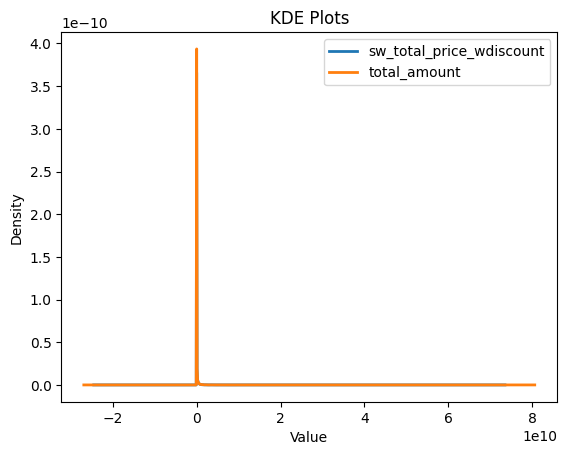

In [37]:
simple_df["sw_total_price_wdiscount"].plot(kind='kde', label="sw_total_price_wdiscount", linewidth=2)
simple_df["total_amount"].plot(kind='kde', label="total_amount", linewidth=2)
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("KDE Plots")
plt.legend()
plt.show()


In [38]:
from scipy.stats import skew, kurtosis

print(f"Skewness of sw_total_price_wdiscount: {skew(simple_df['sw_total_price_wdiscount'])}")
print(f"Kurtosis of sw_total_price_wdiscount: {kurtosis(simple_df['sw_total_price_wdiscount'])}")

print(f"Skewness of total_amount: {skew(simple_df['total_amount'])}")
print(f"Kurtosis of total_amount: {kurtosis(simple_df['total_amount'])}")


Skewness of sw_total_price_wdiscount: 160.79409574579063
Kurtosis of sw_total_price_wdiscount: 48862.42913746919
Skewness of total_amount: 151.94442939699914
Kurtosis of total_amount: 44408.29050472621


In [53]:
simple_df["sw_total_price_wdiscount"].value_counts()

sw_total_price_wdiscount
0.0          225058
30000.0       21099
15000.0       20362
10000.0       20294
6000.0        19294
              ...  
126325.0          1
1934520.2         1
8794695.0         1
1124010.0         1
412129.0          1
Name: count, Length: 687286, dtype: int64

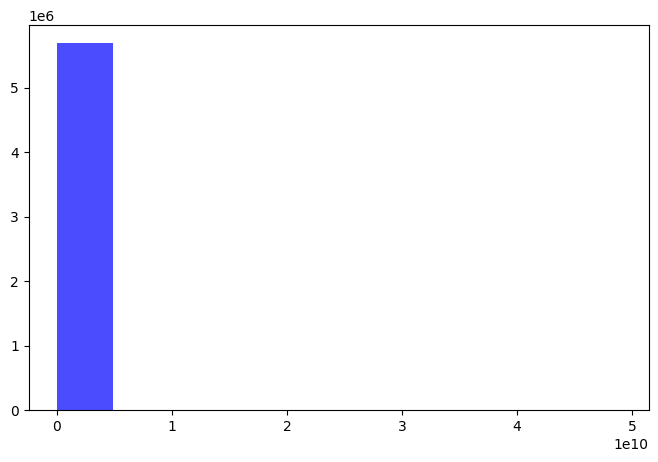

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Histogram
plt.figure(figsize=(8, 5))
plt.hist(simple_df["sw_total_price_wdiscount"], alpha=0.7, color="blue", label="Original")

plt.show()

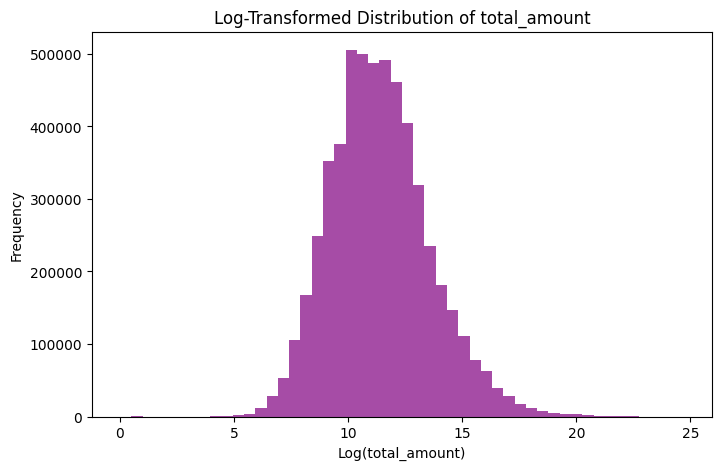

In [69]:
# Log transformation of the values
import numpy as np
simple_df["total_amount_log"] = np.log1p(simple_df["total_amount"])  # log1p avoids issues with 0 values

# Plot the log-transformed histogram
plt.figure(figsize=(8, 5))
plt.hist(simple_df["total_amount_log"], bins=50, alpha=0.7, color="purple")
plt.xlabel("Log(total_amount)")
plt.ylabel("Frequency")
plt.title("Log-Transformed Distribution of total_amount")
plt.show()


In [62]:
df[df.sw_total_price_wdiscount==0]

,advertisement_id,lot_id,fw_item_price,fw_total_price,fw_discount,fw_total_price_wdiscount,sw_item_price,sw_total_price,sw_discount,sw_total_price_wdiscount,...,participant_parent_company,participant_oked_list,participant_kse_code,participant_is_world_company,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_patronymic_producer,participant_is_patronymic_supplier,participant_is_small_employer,participant_is_single_org
46,8226952,21853017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,84120.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,5289999,13248710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,85100.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
156,7659525,20426069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,84120.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
257,5421885,13711838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,85100.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
281,5372884,13520013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,84120.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034170,9354314,24340625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,85310.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6034192,9225889,24027956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,85100.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6034212,8809990,23150943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,85310.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6034216,5468662,13901546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,85100.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [67]:
simple_df = simple_df.loc[~(simple_df==0).any(axis=1)]


simple_df[simple_df.sw_total_price_wdiscount==0]

,sw_total_price_wdiscount,total_amount


In [68]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
X = simple_df[["total_amount"]]
y = simple_df["sw_total_price_wdiscount"] + 1

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict with Linear Model
y_pred_linear = lin_reg.predict(X_test)

# Transform target to log-space
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Train Logarithmic Model
log_reg = LinearRegression()
log_reg.fit(X_train, y_train_log)

# Predict in log-space
y_pred_log = log_reg.predict(X_test)

# Convert predictions back to original scale
y_pred_log_exp = np.exp(y_pred_log)

# Evaluate Linear Model
r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)

# Evaluate Logarithmic Model
r2_log = r2_score(y_test, y_pred_log_exp)
mse_log = mean_squared_error(y_test, y_pred_log_exp)

# Display results
print("Linear Model:")
print(f"  R² Score: {r2_linear}")
print(f"  MSE: {mse_linear}")

print("\nLogarithmic Model:")
print(f"  R² Score: {r2_log}")
print(f"  MSE: {mse_log}")


Linear Model:
  R² Score: 0.9957450324035704
  MSE: 33262522450115.41

Logarithmic Model:
  R² Score: -1.4862953360603427e+93
  MSE: 1.1618873907451705e+109


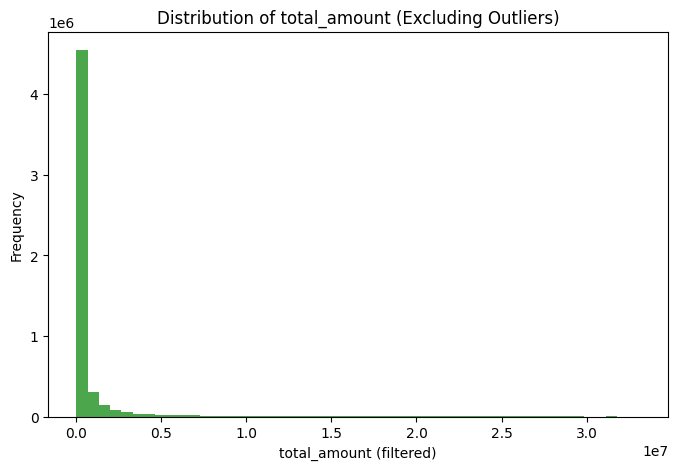

In [71]:
# Exclude outliers (e.g., values above the 99th percentile)
threshold = np.percentile(simple_df["total_amount"], 99)
filtered_data = simple_df[simple_df["total_amount"] <= threshold]

# Plot filtered histogram
plt.figure(figsize=(8, 5))
plt.hist(filtered_data["total_amount"], bins=50, alpha=0.7, color="green")
plt.xlabel("total_amount (filtered)")
plt.ylabel("Frequency")
plt.title("Distribution of total_amount (Excluding Outliers)")
plt.show()


/var/folders/yr/yydj312117b_npm8qzq0jhf40000gn/T/ipykernel_73832/1990848984.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["sw_total_price_wdiscount_log"] = np.log1p(filtered_data["sw_total_price_wdiscount"])  # log1p avoids issues with 0 values


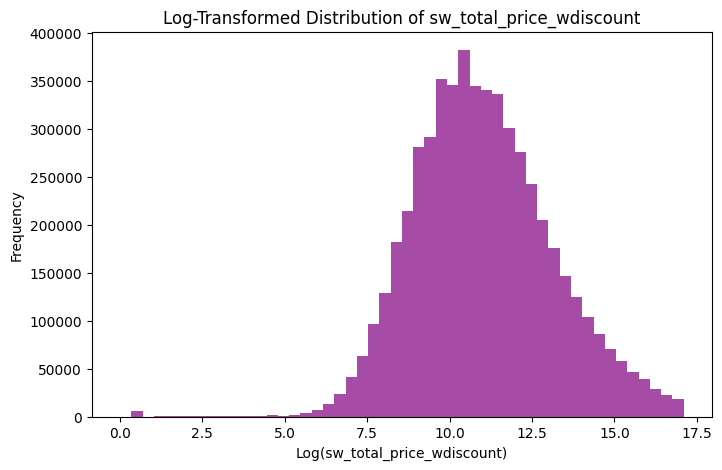

/var/folders/yr/yydj312117b_npm8qzq0jhf40000gn/T/ipykernel_73832/1990848984.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["total_amount_log"] = np.log1p(filtered_data["total_amount"])  # log1p avoids issues with 0 values


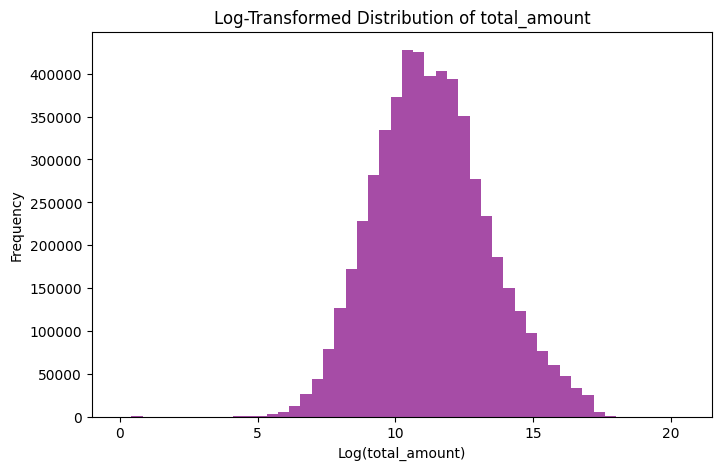

In [74]:
# Log transformation of the values
import numpy as np

threshold_tot_am = np.percentile(simple_df["total_amount"], 99)
threshold_sw_total = np.percentile(simple_df["sw_total_price_wdiscount"], 99)

filtered_data = simple_df[simple_df["total_amount"] <= threshold_tot_am]
filtered_data = simple_df[simple_df["sw_total_price_wdiscount"] <= threshold_sw_total]


filtered_data["sw_total_price_wdiscount_log"] = np.log1p(filtered_data["sw_total_price_wdiscount"])  # log1p avoids issues with 0 values

# Plot the log-transformed histogram
plt.figure(figsize=(8, 5))
plt.hist(filtered_data["sw_total_price_wdiscount_log"], bins=50, alpha=0.7, color="purple")
plt.xlabel("Log(sw_total_price_wdiscount)")
plt.ylabel("Frequency")
plt.title("Log-Transformed Distribution of sw_total_price_wdiscount")
plt.show()

#total amount

filtered_data["total_amount_log"] = np.log1p(filtered_data["total_amount"])  # log1p avoids issues with 0 values

# Plot the log-transformed histogram
plt.figure(figsize=(8, 5))
plt.hist(filtered_data["total_amount_log"], bins=50, alpha=0.7, color="purple")
plt.xlabel("Log(total_amount)")
plt.ylabel("Frequency")
plt.title("Log-Transformed Distribution of total_amount")
plt.show()


In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data
X = filtered_data[["total_amount"]]
y = filtered_data["sw_total_price_wdiscount"] + 1

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict with Linear Model
y_pred_linear = lin_reg.predict(X_test)

# Transform target to log-space
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Train Logarithmic Model
log_reg = LinearRegression()
log_reg.fit(X_train, y_train_log)

# Predict in log-space
y_pred_log = log_reg.predict(X_test)

# Convert predictions back to original scale
y_pred_log_exp = np.exp(y_pred_log)

# Evaluate Linear Model
r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)

# Evaluate Logarithmic Model
r2_log = r2_score(y_test, y_pred_log_exp)
mse_log = mean_squared_error(y_test, y_pred_log_exp)

# Display results
print("Linear Model:")
print(f"  R² Score: {r2_linear}")
print(f"  MSE: {mse_linear}")

print("\nLogarithmic Model:")
print(f"  R² Score: {r2_log}")
print(f"  MSE: {mse_log}")


NameError: name 'filtered_data' is not defined